In [2]:
import numpy as np
import matplotlib.pyplot as plt
from cohlib.utils import pickle_open, logistic
from cohlib.utils import pickle_open
from cohlib.plot import draw_raster_single
from cohlib.sample import sample_spikes_from_xs

from numpy.fft import rfft
from cohlib.mvcn import thr_coherence, estimate_coherence

In [22]:
def reorder_ve2vri(ve):
    """Convert [Re(z1), Im(z1), Re(z2), Im(z2)] to 
        [Re(z1), Re(z2), Im(z1), Im(z2)]
    """
    v_temp = ve.reshape(-1,2)
    v_ri = np.concatenate([v_temp[:,0], v_temp[:,1]])
    return v_ri

def reorder_vri2ve(v_ri):
    v_e = v_ri.reshape(2,-1).flatten(order='F')
    return v_e

In [3]:
def Gamma_est_from_zs(zs, dc=False):
    if dc is True:
        zs_outer = np.einsum('ijk,imk->kjmi', zs[:,:,1:], zs[:,:,1:].conj())
    else:
        zs_outer = np.einsum('ijk,imk->kjmi', zs, zs.conj())
    zs_outer_mean = zs_outer.mean(3)
    return zs_outer_mean
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams[lams < 0] = 0
    return lams

In [4]:
seed = 8
win=1000
L=50
C=1
emiter=20
K=2

link = 'relu'
init_type ='flat'
optim_type ='BFGS'
alpha = 400
alpha=float(alpha)
alphas = np.array([alpha, alpha])

sample_length = win
em_iters = emiter

model_path = f'saved/fitted_models/simple_synthetic_delta{link}poisson_em{em_iters}_{K}_{L}_{sample_length}_{C}_{alpha}_{seed}_{init_type}_{optim_type}_fitted'
data_path = f'saved/synthetic_data/simple_synthetic_delta{link}poisson_fixed_gamma_{K}_{L}_{sample_length}'


model_load = pickle_open(model_path)
data_load = pickle_open(data_path)

In [5]:
r = 5
mus = model_load['track'][0][r]['mus']
Ups_invs = model_load['track'][0][r]['Ups_invs']

In [6]:
from cohlib.utils import (
    transform_cov_r2c,
    transform_cov_c2r,
    rearrange_mat,
    reverse_rearrange_mat,
)
def quick_conv_c2r(ccov, K):
    return reverse_rearrange_mat(transform_cov_c2r(ccov), K)
def quick_conv_r2c(rcov, K):
    return transform_cov_r2c(rearrange_mat(rcov, K))

def get_freq_vecs_real(vec, K, num_J_vars):
    """
    Un-vectorize over frequencies.
    """
    j_vecs = []
    for jv in range(0, num_J_vars, 2):
        base_filt = np.zeros(num_J_vars)
        base_filt[jv : jv + 2] = 1
        j_filt = np.tile(base_filt.astype(bool), K)
        vec_j = vec[j_filt]
        j_vecs.append(vec_j)
    return j_vecs

In [7]:
delta = 1e-3
Wv = model_load['Wv']
num_J_vars = Wv.shape[1]
Gamma_true = data_load['latent']['Gamma'][:int(num_J_vars/2)]
Gamma_true.shape
spikes = model_load['spikes']
lams_true = model_load['lams']

if spikes.shape[1] == 1:
    spikes = spikes[:,0,:,:]

# gamma_r = model_load['track'][0][r-1]['gamma']
# gamma_r_inv = np.stack([np.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
Gamma_true_inv = np.linalg.inv(Gamma_true)
Gamma_true.shape
J = int(num_J_vars/2)

Gamma_real = np.stack([reverse_rearrange_mat(transform_cov_c2r(Gamma_true[j,:,:]), K) for j in range(J)])
Gamma_real_inv = np.stack([reverse_rearrange_mat(transform_cov_c2r(Gamma_true_inv[j,:,:]), K) for j in range(J)])


In [8]:
r = 1
mus = model_load['track'][0][r]['mus']
Ups_invs = model_load['track'][0][r]['Ups_invs']
Sig_complex = model_load['track'][0][r]['Sig_complex']

In [9]:
Wv.shape

(1000, 98)

In [10]:
num_J_vars = Wv.shape[1]
vec = mus[0,:]
j_vecs = []
for jv in range(0, num_J_vars, 2):
    base_filt = np.zeros(num_J_vars)
    base_filt[jv : jv + 2] = 1
    j_filt = np.tile(base_filt.astype(bool), K)
    vec_j = vec[j_filt]
    j_vecs.append(vec_j)

In [11]:
def get_freq_vecs_real(vec, K, num_J_vars):
    """
    Un-vectorize over frequencies.
    """
    j_vecs = []
    for jv in range(0, num_J_vars, 2):
        base_filt = np.zeros(num_J_vars)
        base_filt[jv : jv + 2] = 1
        j_filt = np.tile(base_filt.astype(bool), K)
        vec_j = vec[j_filt]
        j_vecs.append(vec_j)
    return j_vecs

In [12]:
jv = 5
base_filt = np.zeros(num_J_vars)
base_filt[jv : jv + 2] = 1
j_filt = np.tile(base_filt.astype(bool), K)
j_filt = np.tile(base_filt.astype(bool), K)
vec_j = vec[j_filt]
j_vecs.append(vec_j)

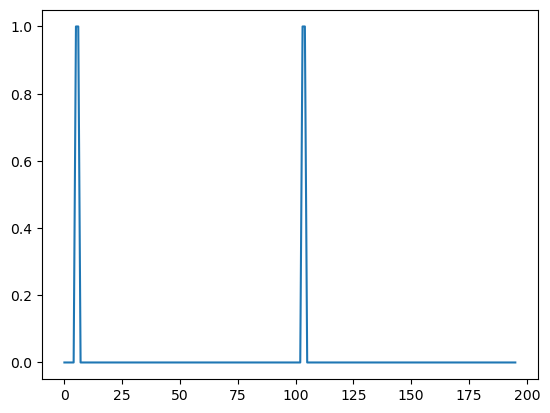

In [13]:
plt.plot(j_filt)

In [52]:
from scipy.linalg import block_diag
from cohlib.alg.em_sgc import get_freq_vecs_real
L = mus.shape[0]

J = int(num_J_vars / 2)
mus_outer = np.zeros((L, J, K * 2, K * 2))
Upss = np.zeros((L, J, K * 2, K * 2))

for l in range(L):
    Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
    mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
    for j in range(J):
        mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
        Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

mus_conv = np.zeros((L, J, K * 2, K * 2))
Ups_invs_conv = np.zeros((L, J, K * 2, K * 2))

for l in range(L):
    Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
    mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
    for j in range(J):
        mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
        Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

# enforce circulary symmetry
k_mask_pre = 1 - np.eye(2)
k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
k_mask = 1 - k_mask_inv

Gamma_update_complex = np.zeros((J, K, K), dtype=complex)
Sigmas_complex = np.zeros((L, J, K, K), dtype=complex)
for l in range(L):
    Sig_real = mus_outer[l, :, :, :] * k_mask + Upss[l, :, :, :]
    Sig_complex = np.zeros((J, K, K), dtype=complex)
    for j in range(J):
        Sig_complex[j, :, :] = transform_cov_r2c(
            rearrange_mat(Sig_real[j, :, :], K)
        )
    Gamma_update_complex += Sig_complex
    Sigmas_complex[l,:,:,:] = Sig_complex

Gamma_update_complex_old = Gamma_update_complex / L

In [15]:
mu_js[j]

array([-4.27182147e-04, -6.18201933e-04,  1.79713002e-04, -5.24736562e-05])

In [44]:
def complex_outer_realrep(rvec, order='frequency'):
    # if rvec is ordered [Re(z1), Im(z1), Re(z2), Im(z2), ... Re(zJ), Im(zJ)]
    # convert to [Re(z1), Re(z2), ... Re(zJ), Im(z1), Im(z2), ..., Im(zJ)]
    K = int(rvec.size/2)
    if order == 'frequency':
        rvec = reorder_ve2vri(rvec)
    elif order == 'realimag':
        pass
    else:
        raise ValueError

    v_outer_ri = np.outer(rvec, rvec)

    v_outer_ri_corrected = transform_cov_c2r(transform_cov_r2c(v_outer_ri))
    v_outer = rearrange_mat(v_outer_ri_corrected, K)

    return v_outer

In [53]:

from scipy.linalg import block_diag
from cohlib.alg.em_sgc import get_freq_vecs_real
L = mus.shape[0]

J = int(num_J_vars / 2)
mus_outer = np.zeros((L, J, K * 2, K * 2))
Upss = np.zeros((L, J, K * 2, K * 2))

for l in range(L):
    Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
    mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
    for j in range(J):
        mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
        Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

mus_conv = np.zeros((L, J, K * 2, K * 2))
Ups_invs_conv = np.zeros((L, J, K * 2, K * 2))

for l in range(L):
    Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
    mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
    for j in range(J):
        mus_outer[l, j, :, :] = complex_outer_realrep(mu_js[j], order='frequency')
        Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

# enforce circulary symmetry
k_mask_pre = 1 - np.eye(2)
k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
k_mask = 1 - k_mask_inv

Gamma_update_complex = np.zeros((J, K, K), dtype=complex)
Sigmas_complex = np.zeros((L, J, K, K), dtype=complex)
for l in range(L):
    Sig_real = mus_outer[l, :, :, :] * k_mask + Upss[l, :, :, :]
    Sig_complex = np.zeros((J, K, K), dtype=complex)
    for j in range(J):
        Sig_complex[j, :, :] = transform_cov_r2c(
            rearrange_mat(Sig_real[j, :, :], K)
        )
    Gamma_update_complex += Sig_complex
    Sigmas_complex[l,:,:,:] = Sig_complex

Gamma_update_complex_new = Gamma_update_complex / L

In [57]:
print(Gamma_update_complex_old[5,:,:])
print(Gamma_update_complex_new[5,:,:])

[[1.59999998e+00+0.00000000e+00j 2.42898765e-08+2.61181478e-08j]
 [2.42898765e-08-2.61181478e-08j 1.60000000e+00+0.00000000e+00j]]
[[1.59999998e+00+0.00000000e+00j 2.42898765e-08+2.61181478e-08j]
 [2.42898765e-08-2.61181478e-08j 1.60000000e+00+0.00000000e+00j]]


In [58]:
np.all(np.isclose(Gamma_update_complex_old, Gamma_update_complex_new))

True

In [41]:
mu_j = mu_js[j]

In [42]:
mu_j

array([-4.27182147e-04, -6.18201933e-04,  1.79713002e-04, -5.24736562e-05])

In [45]:
mu_j_outer = np.outer(mu_j, mu_j)
mu_j_outer_corrected = complex_outer_realrep(mu_j, order='frequency')

In [46]:
np.round(mu_j_outer, 9)

array([[ 1.82e-07,  2.64e-07, -7.70e-08,  2.20e-08],
       [ 2.64e-07,  3.82e-07, -1.11e-07,  3.20e-08],
       [-7.70e-08, -1.11e-07,  3.20e-08, -9.00e-09],
       [ 2.20e-08,  3.20e-08, -9.00e-09,  3.00e-09]])

In [47]:
np.round(mu_j_outer_corrected, 9)

array([[ 2.82e-07, -0.00e+00, -2.20e-08,  6.70e-08],
       [ 0.00e+00,  2.82e-07, -6.70e-08, -2.20e-08],
       [-2.20e-08, -6.70e-08,  1.80e-08, -0.00e+00],
       [ 6.70e-08, -2.20e-08,  0.00e+00,  1.80e-08]])

In [36]:
def update_Gamma_complex(mus, Ups_invs, K, num_J_vars):
    """
    M-Step

    mus is (trials x num_J_vars * K)
    Ups_inv is (trials x num_J_vars * K x num_J_vars * K)
    """
    L = mus.shape[0]

    J = int(num_J_vars / 2)
    mus_outer = np.zeros((L, J, K * 2, K * 2))
    Upss = np.zeros((L, J, K * 2, K * 2))

    for l in range(L):
        Ups_inv_j_vecs = get_freq_vecs_real(np.diag(Ups_invs[l, :, :]), K, num_J_vars)
        mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
        for j in range(J):
            mus_outer[l, j, :, :] = np.outer(mu_js[j], mu_js[j])
            Upss[l, j, :, :] = -np.diag(1 / Ups_inv_j_vecs[j])

    # enforce circulary symmetry
    k_mask_pre = 1 - np.eye(2)
    k_mask_inv = block_diag(*[k_mask_pre for k in range(K)])
    k_mask = 1 - k_mask_inv

    Gamma_update_complex = np.zeros((J, K, K), dtype=complex)
    Sigmas_complex = np.zeros((L, J, K, K), dtype=complex)
    for l in range(L):
        Sig_real = mus_outer[l, :, :, :] * k_mask + Upss[l, :, :, :]
        Sig_complex = np.zeros((J, K, K), dtype=complex)
        for j in range(J):
            Sig_complex[j, :, :] = transform_cov_r2c(
                rearrange_mat(Sig_real[j, :, :], K)
            )
        Gamma_update_complex += Sig_complex
        Sigmas_complex[l,:,:,:] = Sig_complex

    Gamma_update_complex = Gamma_update_complex / L

    return Gamma_update_complex, Sigmas_complex

In [49]:
l = 0
j = 5
mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
mu_j = np.round(mu_js[j], 4)
mu_j_ri = np.round(reorder_ve2vri(mu_j),4)
print(mu_j)
print(mu_j_ri)

[0.0085 0.133  0.0232 0.0726]
[0.0085 0.0232 0.133  0.0726]


In [51]:
mu_j_outer = np.outer(mu_j, mu_j)
mu_j_ri_outer = np.outer(mu_j_ri, mu_j_ri)
print(mu_j_outer)
print(mu_j_ri_outer)

[[7.22500e-05 1.13050e-03 1.97200e-04 6.17100e-04]
 [1.13050e-03 1.76890e-02 3.08560e-03 9.65580e-03]
 [1.97200e-04 3.08560e-03 5.38240e-04 1.68432e-03]
 [6.17100e-04 9.65580e-03 1.68432e-03 5.27076e-03]]
[[7.22500e-05 1.97200e-04 1.13050e-03 6.17100e-04]
 [1.97200e-04 5.38240e-04 3.08560e-03 1.68432e-03]
 [1.13050e-03 3.08560e-03 1.76890e-02 9.65580e-03]
 [6.17100e-04 1.68432e-03 9.65580e-03 5.27076e-03]]


In [53]:
mu_j_outer_rearrange = rearrange_mat(mu_j_outer, K)

In [55]:
np.isclose(mu_j_outer_rearrange, mu_j_ri_outer)

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [58]:
mu_js

array([ 1.89371727, -0.0114026 , -0.07386126,  0.23647541])

In [68]:
# l = 0
# j = 5
# mu_js = get_freq_vecs_real(mus[l, :], K, num_J_vars)
K = 3
mu_j = np.random.randn(int(2*K))
mu_j = np.round(mu_j, 4)
mu_j_ri = np.round(reorder_ve2vri(mu_j),4)
print(mu_j)
print(mu_j_ri)

[ 1.364   0.2437  1.2621  0.4404 -0.9192 -0.7717]
[ 1.364   1.2621 -0.9192  0.2437  0.4404 -0.7717]


In [69]:
mu_j_outer = np.outer(mu_j, mu_j)
mu_j_ri_outer = np.outer(mu_j_ri, mu_j_ri)
print(mu_j_outer)
print(mu_j_ri_outer)

[[ 1.860496    0.3324068   1.7215044   0.6007056  -1.2537888  -1.0525988 ]
 [ 0.3324068   0.05938969  0.30757377  0.10732548 -0.22400904 -0.18806329]
 [ 1.7215044   0.30757377  1.59289641  0.55582884 -1.16012232 -0.97396257]
 [ 0.6007056   0.10732548  0.55582884  0.19395216 -0.40481568 -0.33985668]
 [-1.2537888  -0.22400904 -1.16012232 -0.40481568  0.84492864  0.70934664]
 [-1.0525988  -0.18806329 -0.97396257 -0.33985668  0.70934664  0.59552089]]
[[ 1.860496    1.7215044  -1.2537888   0.3324068   0.6007056  -1.0525988 ]
 [ 1.7215044   1.59289641 -1.16012232  0.30757377  0.55582884 -0.97396257]
 [-1.2537888  -1.16012232  0.84492864 -0.22400904 -0.40481568  0.70934664]
 [ 0.3324068   0.30757377 -0.22400904  0.05938969  0.10732548 -0.18806329]
 [ 0.6007056   0.55582884 -0.40481568  0.10732548  0.19395216 -0.33985668]
 [-1.0525988  -0.97396257  0.70934664 -0.18806329 -0.33985668  0.59552089]]


In [70]:
mu_j_outer_rearrange = rearrange_mat(mu_j_outer, K)

In [71]:
np.isclose(mu_j_ri_outer, mu_j_outer)

array([[ True, False, False, False, False,  True],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [ True, False, False, False, False,  True]])

In [72]:
np.isclose(mu_j_outer_rearrange, mu_j_ri_outer)

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True]])

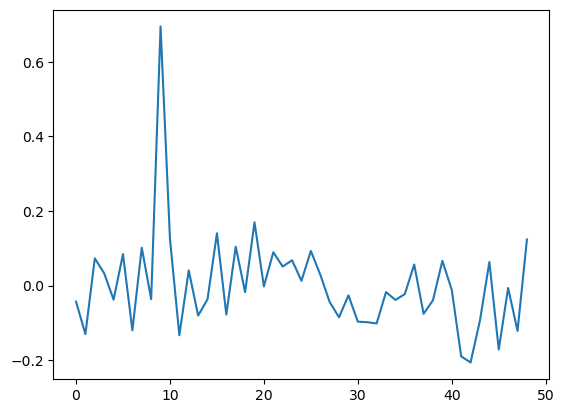

In [33]:
plt.plot(mu_js[:,3])